In [1]:
# Librerías y paquetes
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast
import colorednoise as cn
import random 
import pickle as pkl

In [2]:
from pathlib import Path
def make_gravitational_waves(
    path_to_data: Path,
    n_signals: int = 30,
    downsample_factor: int = 2,
    r_min: float = 0.075,
    r_max: float = 0.65,
    n_snr_values: int = 1,
        ):
    
    def padrand(V, n, kr):
        cut = np.random.randint(n)
        rand1 = np.random.randn(cut)
        rand2 = np.random.randn(n - cut)
        out = np.concatenate((rand1 * kr, V, rand2 * kr))
        return out

    Rcoef = np.linspace(r_min, r_max, n_snr_values)
    Npad =500  # number of padding points on either side of the vector
    #gw = np.load(path_to_data / "gravitational_wave_signals.npy")
    #../input/gravitational-wave-signals/gravitational_wave_signals.npy
    gw = np.load("gravitational_wave_signals.npy")
    Norig = len(gw["data"][0])
    Ndat = len(gw["signal_present"])
    N = int(Norig / downsample_factor)

    ncoeff = []
    Rcoeflist = []

    for j in range(n_signals):
        ncoeff.append(10 ** (-19) * (1 / Rcoef[j % n_snr_values]))
        Rcoeflist.append(Rcoef[j % n_snr_values])

    noisy_signals = []
    gw_signals = []
    k = 0
    labels = np.zeros(n_signals)

    for j in range(n_signals):
        signal = gw["data"][j % Ndat][range(0, Norig, downsample_factor)]
        sigp = int((np.random.randn() < 0))
        noise = ncoeff[j] * np.random.randn(N)
        labels[j] = sigp
        if sigp == 1:
            rawsig = padrand(signal + noise, Npad, ncoeff[j])
            if k == 0:
                k = 1
        else:
            rawsig = padrand(noise, Npad, ncoeff[j])
        noisy_signals.append(rawsig.copy())
        gw_signals.append(signal)

    return noisy_signals, gw_signals, labels

In [25]:
#from data.generate_datasets import make_gravitational_waves
from pathlib import Path

n_signals = 1500
DATA = Path("./data")

noisy_gausignals, gw_gausignals, gau_labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=0.025, r_max=0.65, n_snr_values=100
)



In [32]:
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# get the index corresponding to the first pure noise time series
background_idx = np.argmin(gau_labels)
# get the index corresponding to the first noise + gravitational wave time series
signal_idx = np.argmax(gau_labels)

print(background_idx, signal_idx)

ts_noise = noisy_gausignals[background_idx]
ts_background = noisy_gausignals[signal_idx]
ts_signal = gw_gausignals[signal_idx]

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_noise))), y=ts_noise, mode="lines", name="noise"),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=list(range(len(ts_background))),
        y=ts_background,
        mode="lines",
        name="background",
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_signal))), y=ts_signal, mode="lines", name="signal"),
    row=1,
    col=2,
)
fig.show()

2 0


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [6]:
# Making the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [44]:
from sklearn.model_selection import train_test_split

from pathlib import Path

#Function to create the data set
def create_dataset(r, num_signal ,DATA):

    DATA = Path("./data")
    n_signals = num_signal

    noisy_gausignals, gw_gausignals, gau_labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=r, r_max=r, n_snr_values=1)

    return noisy_gausignals, gw_gausignals, gau_labels




In [26]:
def prepocess_data(noisy_gausignals, gau_labels):
    data = np.array(noisy_gausignals)

    #Scale the data
    data = data / np.max(data)

    # Convert the data end labels to PyTorch tensors
    data = torch.tensor(data, dtype=torch.float32).to(device)
    labels = torch.tensor(gau_labels, dtype=torch.float32).to(device)


    #Unsqueeze the data to add a channel dimension
    data = data.unsqueeze(1)

    # Split data into training and testing sets
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

    # print the amount of 1 in the labels
    #print(f"Number of 1s in the labels: {int(torch.sum(test_labels))}")
    #print(f"Number of 0s in the labels: {len(test_labels) - int(torch.sum(test_labels))}")



    # Create TensorDatasets for training and testing
    train_dataset = TensorDataset(train_data, train_labels)
    test_dataset = TensorDataset(test_data, test_labels)

    # Create DataLoaders for training and testing
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    #Shape of the data
    #print(f"Shape of the training data: {train_data.shape}")

    return data, train_data, test_data, train_labels, test_labels, train_loader, test_loader

In [27]:
data, train_data, test_data, train_labels, test_labels, train_loader, test_loader = prepocess_data(noisy_gausignals, gau_labels)

In [28]:
class GWCNN(nn.Module):
    def __init__(self):
        super(GWCNN, self).__init__()
      # First convolution block
        self.conv1 = nn.Conv1d(1, 64, kernel_size=16, stride=1)
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=4)
        self.fc1 = nn.Linear(2169, 512)  # 'reduced_dim1' needs to be calculated
        self.act1 = nn.ReLU()

        # Second convolution block
        self.conv2 = nn.Conv1d(64, 128, kernel_size=16, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=4, padding=0)
        self.fc2 = nn.Linear(125, 128)  # 'reduced_dim2' needs to be calculated
        self.act2 = nn.ReLU()
        
        # Third convolution block
        self.conv3 = nn.Conv1d(128, 256, kernel_size=4, stride=1, padding=1)
        self.maxpool3 = nn.MaxPool1d(kernel_size=2, stride=4, padding=0)
        self.fc3 = nn.Linear(32, 32)  # 'reduced_dim3' needs to be calculated
        self.act3 = nn.ReLU()

        # Fourth convolution block
        self.conv4 = nn.Conv1d(256, 512, kernel_size=8, stride=1)
        self.maxpool4 = nn.MaxPool1d(kernel_size=4, stride=4)
        self.fc4 = nn.Linear(6, 4)  # 'reduced_dim4' needs to be calculated
        self.act4 = nn.ReLU()

        # Flattening for final dense layers
        self.flatten = nn.Flatten()
        self.fc5 = nn.Linear(2048, 512)
        self.act5 = nn.ReLU()
        self.fc6 = nn.Linear(512, 128)
        self.act6 = nn.ReLU()
        self.fc7 = nn.Linear(128, 32)
        self.act7 = nn.ReLU()
        self.fc8 = nn.Linear(32, 2)

    def forward(self, x):
        
        # First convolution block
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.fc1(x)
        x = self.act1(x)
        #print("Bloque 1: ", x.shape)

        # Second convolution block
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.fc2(x)
        x = self.act2(x)
        #print("Bloque 2: ", x.shape)
        
        # Third convolution block
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.fc3(x)
        x = self.act3(x)
        #print("Bloque 3: ", x.shape)

        # Fourth convolution block
        x = self.conv4(x)
        x = self.maxpool4(x)
        x = self.fc4(x)
        x = self.act4(x)
        #print("Bloque 4: ", x.shape)

        # Flattening for final dense layers
        x = self.flatten(x)
        
        x = self.fc5(x)
        x = self.act5(x)
      
        x = self.fc6(x)
        x = self.act6(x)

        x = self.fc7(x)
        x = self.act7(x)

        x = self.fc8(x)
        #print("GG")
        return x

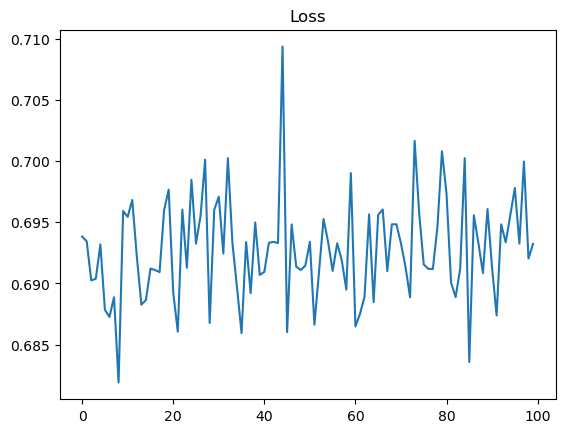

In [29]:
model = GWCNN().to(device)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

losses = []

# Training loop
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels.long())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #save the loss of each epoch for plotting but only the first 2 digits
    losses.append(loss.item())


#plot the loss
plt.plot(losses) 
plt.title("Loss")
plt.show()

# Save the trained model
# torch.save(model.state_dict(), "GW_Paper.pth")

In [33]:
#test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted = predicted.cpu().numpy()
        print(predicted)


print(f"Accuracy: {100 * correct / total}")

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0]
Accuracy: 49.666666666666664


<Axes: >

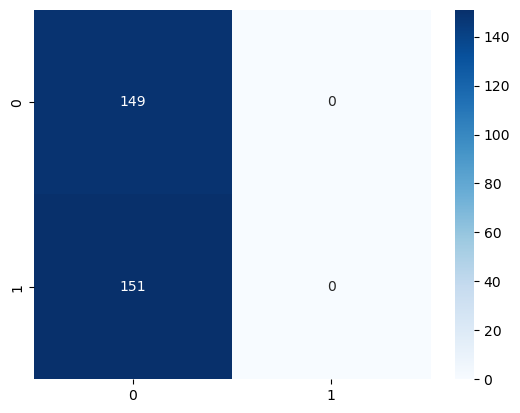

In [34]:
#create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
preds = []
true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        preds.extend(predicted.cpu().numpy())
        true.extend(labels.cpu().numpy())

cm = confusion_matrix(true, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [55]:
def training_overdrive(i,j):

    # i = 
    # j = numero de señales
    accuracy = []
    r_intento = []
    #Do i- times
    y = 1/50
    for x in range(2*i):
        noisy_gausignals, gw_gausignals, gau_labels = create_dataset((x+1)*y, j,DATA)
        print(f"Training with r = {(x+1)*y}")
        data, train_data, test_data, train_labels, test_labels, train_loader, test_loader = prepocess_data(noisy_gausignals, gau_labels)
        model = GWCNN().to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

        n_epochs = 50

        for epoch in range(n_epochs):
            model.train()
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                y_pred = model(inputs)
                loss = loss_fn(y_pred, labels.long())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        #filename = f"GW_Paper_{x+1}.pth"
       # torch.save(model.state_dict(), filename)
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                predicted = predicted.cpu().numpy()
                print(predicted)
        print(f"Accuracy: {100 * correct / total}")
        #append the accuracy to the list
        accuracy.append(100 * correct / total)
        r_intento.append((x+1)*y)

    return accuracy, r_intento


In [53]:
accuracy, r_intento = training_overdrive(50,500)

Training with r = 0.02
[0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 1 1 1 0]
[0 1 1 0 1 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0]
[0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0]
[0 1 1 1]
Accuracy: 48.0
Training with r = 0.04
[0 1 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1]
[0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1]
[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0]
[0 1 0 1]
Accuracy: 48.0


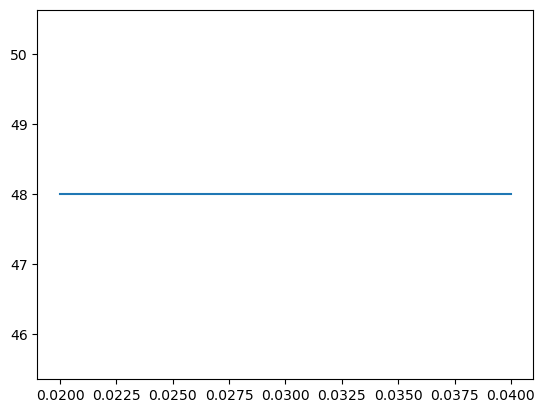

In [54]:
#plot the accuracy vs r_intento
plt.plot(r_intento, accuracy)
